In [1]:

import numpy as np
import tensorflow
import tensorflow as tf

import matplotlib.pyplot as plt

import gpflow

from scipy.stats import norm

from gpflow.functions import Constant, Polynomial

from rcgp.rcgp.rcgp import RCGPR
from rcgp.rcgp.w import IMQ

plt.rc('font', family='serif', size=16)
plt.rcParams['text.usetex'] = True

In [2]:
def coverage(preds, std, Ys):
    quantiles = np.append(np.arange(0.05, 1, 0.05), 0.9973)
    coverage_vals = []
    for confidence_level in quantiles:
        z_val = norm.ppf(1 - (1 - confidence_level)/2)
        lb = preds - z_val * std
        ub = preds + z_val * std

        is_within_bounds = (Ys >= lb) & (Ys <= ub)
        coverage_vals.append(is_within_bounds.mean())
    
    return quantiles, coverage_vals

In [3]:
class CustomMeanFunction(gpflow.functions.MeanFunction):
    def __call__(self, X: gpflow.base.TensorType) -> tf.Tensor:
        return 2.5*tf.sin(2 * np.pi * X)

In [4]:
"""def generate_data(lengthscale, variance_kernel, var_y, n, seed=0):
    np.random.seed(seed)
    kernel = gpflow.kernels.SquaredExponential(variance=variance_kernel, lengthscales=lengthscale)
    X = np.linspace(-5, 5, n)[:, None]  # 100 points in [-5, 5]

    # Compute the covariance matrix using the kernel
    K = kernel(X).numpy()  # Kernel matrix

    # Add a small jitter for numerical stability
    jitter = 1e-6
    K += jitter * np.eye(len(X))

    # Generate samples from the Gaussian Process
    mean = np.zeros(len(X))  # Mean function (zero mean)
    mean_func = np.random.multivariate_normal(mean, K, size=1).flatten()  # 3 sample paths

    y = mean_func +  np.random.normal(0, np.sqrt(var_y), size=len(X))

    return X.flatten(), y.flatten(), mean_func"""


'def generate_data(lengthscale, variance_kernel, var_y, n, seed=0):\n    np.random.seed(seed)\n    kernel = gpflow.kernels.SquaredExponential(variance=variance_kernel, lengthscales=lengthscale)\n    X = np.linspace(-5, 5, n)[:, None]  # 100 points in [-5, 5]\n\n    # Compute the covariance matrix using the kernel\n    K = kernel(X).numpy()  # Kernel matrix\n\n    # Add a small jitter for numerical stability\n    jitter = 1e-6\n    K += jitter * np.eye(len(X))\n\n    # Generate samples from the Gaussian Process\n    mean = np.zeros(len(X))  # Mean function (zero mean)\n    mean_func = np.random.multivariate_normal(mean, K, size=1).flatten()  # 3 sample paths\n\n    y = mean_func +  np.random.normal(0, np.sqrt(var_y), size=len(X))\n\n    return X.flatten(), y.flatten(), mean_func'

In [5]:
"""obs_grid, obs, mean_func = generate_data(1., 0.2, 0.01, 80, seed=3)


obs_outliers = obs.copy()
outliers_idx = [45, 46, 47, 48, 49]
obs_outliers[outliers_idx] = np.random.normal(obs.mean()+2, 0.3, len(outliers_idx))

plt.plot(obs_grid, obs, '.')
plt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')
plt.plot(obs_grid, mean_func, color='black')"""

"obs_grid, obs, mean_func = generate_data(1., 0.2, 0.01, 80, seed=3)\n\n\nobs_outliers = obs.copy()\noutliers_idx = [45, 46, 47, 48, 49]\nobs_outliers[outliers_idx] = np.random.normal(obs.mean()+2, 0.3, len(outliers_idx))\n\nplt.plot(obs_grid, obs, '.')\nplt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')\nplt.plot(obs_grid, mean_func, color='black')"

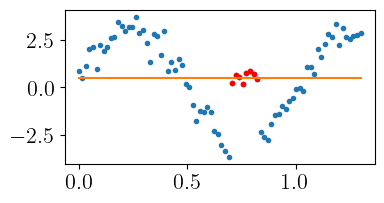

In [6]:
np.random.seed(0)
n_data = 80
n_outliers = 8

obs_grid = np.linspace(0., 1.3, n_data)
obs = 3 * np.sin(2 * np.pi * obs_grid) + np.random.normal(0, 0.5, len(obs_grid))

center_outliers = 43
outliers_idx = np.arange(len(obs))[center_outliers : center_outliers + n_outliers]

obs_outliers = obs.copy()

obs_outliers[outliers_idx] = np.random.normal(obs.mean(), 0.2, n_outliers)

plt.figure(figsize=(4,2))
plt.plot(obs_grid, obs_outliers, '.')
plt.plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', color='red')
plt.plot(obs_grid, obs.mean() + np.zeros_like(obs_grid))

In [7]:
"""c = np.quantile(np.abs(obs - SineMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

print("C : ", c)

model = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    # The original notebook does not initialize the parameters to specific values.
    # The results don't seem sensitive to this though, given the fixed noise.
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(obs.mean()),
    noise_variance=0.001
)

# setting C trainable to False is critical in getting this to work
learn_C = False
gpflow.set_trainable(model.weighting_function.C, learn_C)
#gpflow.set_trainable(model.mean_function.c, False)
#gpflow.set_trainable(model.likelihood.variance, False)
#gpflow.set_trainable(model.likelihood.variance, True)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
print(res)
gpflow.utilities.print_summary(model, "notebook")"""


'c = np.quantile(np.abs(obs - SineMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) \n\nprint("C : ", c)\n\nmodel = RCGPR(\n    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),\n    # The original notebook does not initialize the parameters to specific values.\n    # The results don\'t seem sensitive to this though, given the fixed noise.\n    kernel=gpflow.kernels.SquaredExponential(),  \n    weighting_function=IMQ(c),\n    mean_function=Constant(obs.mean()),\n    noise_variance=0.001\n)\n\n# setting C trainable to False is critical in getting this to work\nlearn_C = False\ngpflow.set_trainable(model.weighting_function.C, learn_C)\n#gpflow.set_trainable(model.mean_function.c, False)\n#gpflow.set_trainable(model.likelihood.variance, False)\n#gpflow.set_trainable(model.likelihood.variance, True)\nopt = gpflow.optimizers.Scipy()\nopt_options = dict()\nres = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)\nprint(res)\ngpflow.utilities.

### Constant Mean

In [8]:
c = np.quantile(np.abs(obs - Constant(obs.mean())(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

#Train on non-outliers
model = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=Constant(obs.mean()),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model.weighting_function.C, False)

res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)

#Inference on outliers
model_inference_const = RCGPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=model.kernel,  
    weighting_function=model.weighting_function,
    mean_function=model.mean_function,
    noise_variance=model.likelihood.variance
)

f_mean_dsm_const, f_var_dsm_const = model_inference_const.predict_f(obs_grid.reshape(-1,1), full_cov=False)

f_std_dsm_const = np.sqrt(f_var_dsm_const).flatten()

### Sine Mean

In [9]:
c = np.quantile(np.abs(obs - CustomMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

#Train on non-outliers
model_sine = RCGPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    weighting_function=IMQ(c),
    mean_function=CustomMeanFunction(),
    noise_variance=0.001
)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
gpflow.set_trainable(model_sine.weighting_function.C, False)

res = opt.minimize(model_sine.training_loss_closure(), model_sine.trainable_variables, options=opt_options)

#Inference on Outliers
model_inference_sine = RCGPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=model_sine.kernel,  
    weighting_function=model_sine.weighting_function,
    mean_function=model_sine.mean_function,
    noise_variance=model_sine.likelihood.variance
)

f_mean_dsm_sine, f_var_dsm_sine = model_inference_sine.predict_f(obs_grid.reshape(-1,1), full_cov=False)
f_mean_dsm_sine = f_mean_dsm_sine.numpy().flatten()

f_std_dsm_sine = np.sqrt(f_var_dsm_sine).flatten()

### GP Regression - Constant Mean

In [10]:
std_gp_model = gpflow.models.GPR(
    (obs_grid.reshape(-1,1), obs.reshape(-1,1)),
    kernel=gpflow.kernels.SquaredExponential(),  
    mean_function=Constant(obs.mean()),
    noise_variance=0.1
)

opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(std_gp_model.training_loss_closure(), std_gp_model.trainable_variables, options=opt_options)


std_gp_inference = gpflow.models.GPR(
    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
    kernel=std_gp_model.kernel,  
    mean_function=std_gp_model.mean_function,
    noise_variance=std_gp_model.likelihood.variance
)

f_mean_sgp, f_var_sgp = std_gp_inference.predict_f(obs_grid.reshape(-1,1), full_cov=False)

f_std_sgp = np.sqrt(f_var_sgp).flatten()

In [11]:
c_heuristic = np.quantile(np.abs(obs - CustomMeanFunction()(obs_grid.reshape(-1,1))), 1 - n_outliers/n_data) 

preds_c = []
c_vals = []
coverage_vals_arrs = []

for c_val in [1.0, c_heuristic]:

    #Using last model's var and kernel (sine)
    model_c = RCGPR(
                    (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
                    kernel=model_sine.kernel,  
                    weighting_function=IMQ(C=c_val),
                    mean_function=model_sine.mean_function,
                    noise_variance=model_sine.likelihood.variance
                    )

    f_mean_dsm_c, f_var_dsm_c = model_c.predict_f(obs_grid.reshape(-1,1), full_cov=False)
    f_mean_dsm_c = f_mean_dsm_c.numpy().flatten()
    f_var_dsm_c = f_var_dsm_c.numpy().flatten()
    std = np.sqrt(f_var_dsm_c + model_c.likelihood.variance.numpy())

    quantiles, coverage_vals = coverage(preds=f_mean_dsm_c, std=std, Ys=obs)

    coverage_vals_arrs.append(coverage_vals)
    preds_c.append(f_mean_dsm_c)
    c_vals.append(c_val)

model_best_c = RCGPR(
                (obs_grid.reshape(-1,1), obs_outliers.reshape(-1,1)),
                kernel=model_sine.kernel,  
                weighting_function=IMQ(C=1.0),
                mean_function=model_sine.mean_function,
                noise_variance=model_sine.likelihood.variance
                )

f_mean_model_best_c, f_var_model_best_c = model_best_c.predict_f(obs_grid.reshape(-1,1), full_cov=False)
f_mean_model_best_c = f_mean_model_best_c.numpy().flatten()
f_var_model_best_c = np.sqrt(f_var_model_best_c).flatten()

Text(0.5, 1.0, 'Issue 3')

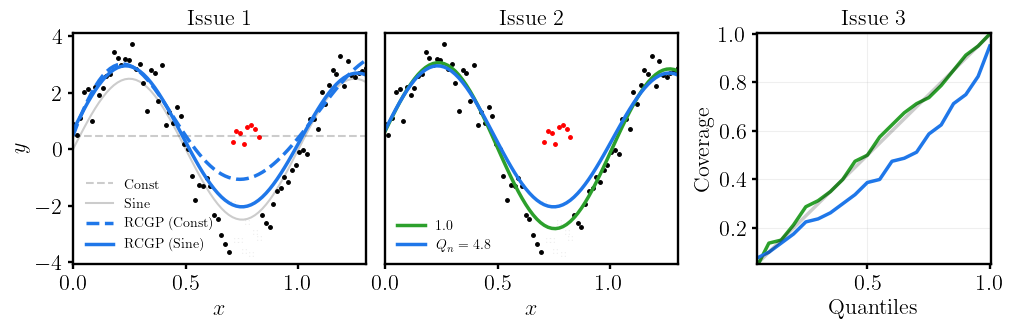

In [ ]:
fig, axs = plt.subplot_mosaic(
    "ABC",
     figsize=(12,3),
     gridspec_kw={"width_ratios": [1.25,1.25,1]},
     )

plt.rcParams['lines.linewidth'] = 2.5


for idx in ["A", "B"]:
    axs[idx].plot(obs_grid, obs, '.', color='black', markersize=5)
    axs[idx].plot(obs_grid[outliers_idx], obs[outliers_idx], '.', color='white', markersize=5.9)
    axs[idx].plot(obs_grid[outliers_idx], obs_outliers[outliers_idx], '.', markersize=5, color='red')

color = "#1f77e9"
#axs['A'].plot(obs_grid, f_mean_sgp, color='green', label='GP (Const.)')
axs['A'].plot(obs_grid, np.zeros_like(obs_grid) + obs.mean(), color='black', alpha=0.2, linestyle='--', linewidth=1.5, label='Const')
axs['A'].plot(obs_grid, model_inference_sine.mean_function(obs_grid).numpy(), color='black', alpha=0.2, linestyle='-', linewidth=1.5, label='Sine')
axs['A'].plot(obs_grid, f_mean_dsm_const, '--', color=color, label='RCGP (Const)')
axs['A'].plot(obs_grid, f_mean_dsm_sine, '-', color=color, label='RCGP (Sine)')

axs['A'].set_xlim(obs_grid[0], obs_grid[-1])
axs['A'].legend(fontsize=10, frameon=False)

#Second Plot
colors = [
    "#2ca02c",   # Forest Green
    "#1f77e9",  # Custom Blue
]
for pred, c_val, col in zip(preds_c, c_vals, colors):
    if c_val == c_heuristic: label=r"$Q_n={:.1f}$".format(c_heuristic)
    else: label=c_val
    axs['B'].plot(obs_grid, pred, color=col, label=label)

axs['B'].set_xlim(obs_grid[0], obs_grid[-1])
axs['B'].legend(fontsize=10, frameon=False, )


#Third Plot
for coverage_vals, col, label in zip(coverage_vals_arrs, colors, c_vals):
    axs['C'].plot(quantiles, coverage_vals, color=col, label=label)

axs['C'].grid(alpha=0.2)
axs['C'].plot(quantiles, quantiles, '-', color='black', alpha=0.2)
axs['C'].set_xlim(quantiles[0], quantiles[-1]+0.005)
axs['C'].set_ylim(quantiles[0], quantiles[-1]+0.005)

axs['C'].set_ylabel("Coverage", fontsize=16)
axs['C'].set_xlabel("Quantiles")

#axs[2].legend()
"""
axs[2].fill_between(obs_grid,
                    f_mean_dsm_sine - 1.96 * np.sqrt(f_std_dsm_sine**2 + model_sine.likelihood.variance),
                    f_mean_dsm_sine + 1.96 * np.sqrt(f_std_dsm_sine**2 + model_sine.likelihood.variance),
                    color=color,
                    alpha=0.2,
                    label=r'$Q_n$')

axs[2].fill_between(obs_grid,
                    f_mean_model_best_c - 1.96 * np.sqrt(f_var_model_best_c + model_best_c.likelihood.variance),
                    f_mean_model_best_c + 1.96 * np.sqrt(f_var_model_best_c + model_best_c.likelihood.variance),
                    color='orange',
                    alpha=0.2,
                    label=r'$Q_n$')"""


for ax in [axs['A'], axs['B'], axs['C']]:
    # Set linewidth for all spines of each axis
    for spine in ax.spines.values():
        spine.set_linewidth(1.7) 
    ax.tick_params(width=1.7)

axs["B"].sharey(axs["A"])
axs["B"].tick_params(left=False, labelleft=False)


# Adjust subplot positions to reduce space between A and B
pos_A = axs["A"].get_position()
pos_B = axs["B"].get_position()
pos_C = axs["C"].get_position()

# Reduce the horizontal space between A and B
axs["A"].set_position([pos_A.x0, pos_A.y0, pos_A.width, pos_A.height])
axs["B"].set_position([pos_B.x0 - 0.03, pos_B.y0, pos_B.width, pos_B.height])
axs["C"].set_position([pos_C.x0 - 0.01, pos_C.y0, pos_C.width, pos_C.height])

axs["A"].set_xlabel(r"$x$")
axs["B"].set_xlabel(r"$x$")
axs["A"].set_ylabel(r"$y$")

"""axs["A"].set_title("Issue 1", fontweight='bold', fontsize=16)
axs["B"].set_title("Issue 2", fontweight='bold', fontsize=16)
axs["C"].set_title("Issue 3", fontweight='bold', fontsize=16)"""

#fig.savefig("./rcgp-issues.pdf", format='pdf', bbox_inches='tight')
